<a href="https://colab.research.google.com/github/akashsukhija/Urban_Land_Cover_Classfication/blob/main/UrbanLandCoverClassfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,cohen_kappa_score,classification_report,confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

## Part 1: Exploratory Data Analysis
### Load the Training Data in a Pandas Dataframe and checking the length of the Dataframe



In [ ]:
df = pd.read_csv("training.csv")
df.head()
print('Length of Training Dataframe:', len(df))

Length of Training Dataframe: 168


### Load the Testing Data in a Pandas Dataframe and checking the length of the Dataframe

In [ ]:
df_2 = pd.read_csv('testing.csv')
print('Length of Testing Dataframe:', len(df_2))

Length of Testing Dataframe: 507


### Creating a Seaborn Countplot to check the Distribution of Classes in Training and Testing Datasets

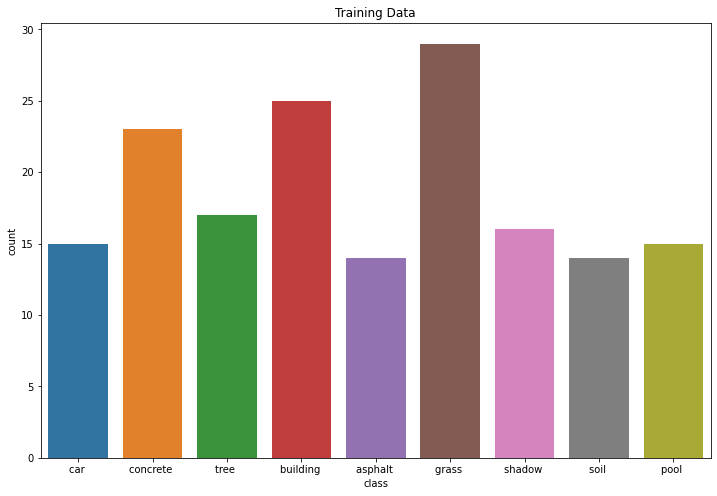

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x='class', data=df).set_title('Training Data');

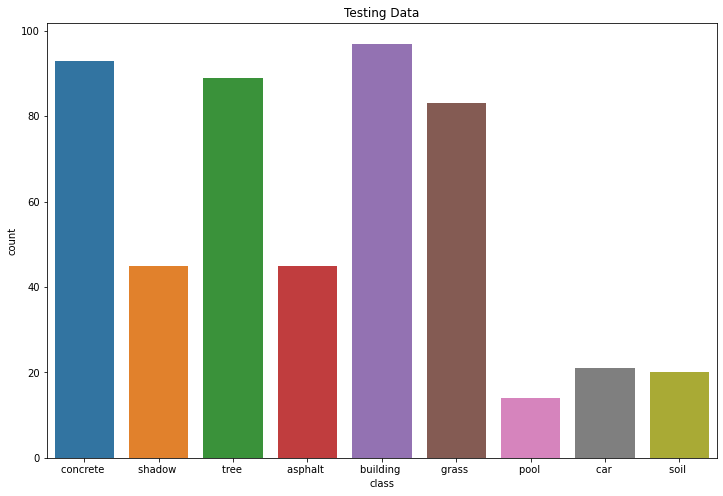

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x='class', data=df_2).set_title('Testing Data');

In [ ]:
print(df['class'].nunique(), "Unique labels:", df['class'].unique())

9 Unique labels: ['car ' 'concrete ' 'tree ' 'building ' 'asphalt ' 'grass ' 'shadow '
 'soil ' 'pool ']


In [ ]:
print(df_2['class'].nunique(), "Unique labels:", df_2['class'].unique())

9 Unique labels: ['concrete ' 'shadow ' 'tree ' 'asphalt ' 'building ' 'grass ' 'pool '
 'car ' 'soil ']


### Assigning Numeric Labels to Classes/Levels in the 'Class' Column of the Training and Testing Dataframe

In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(df['class'])
df['class'] = labelencoder.transform(df['class'])

In [ ]:
df_2['class'] = labelencoder.transform(df_2['class'])

### Shuffling and Splitting the Training Data into Estimation and Validation Datasets

In [ ]:
est_split = 0.7 #defining train and val split

df = df.sample(frac=1).reset_index(drop=True)
df.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,4,1.76,276,0.70,150.70,1.81,1.81,171.22,138.96,141.91,11.05,13.27,11.78,1.25,0.63,0.85,6.87,2.03,0.18,0.10,120,2674.75,2.57,1300,0.94,151.37,2.15,2.68,179.28,134.94,139.87,24.20,21.00,18.97,1.62,0.82,0.80,8.14,2.04,0.42,...,1.61,146.17,1.97,2.50,173.58,129.85,135.08,22.60,22.91,20.89,1.18,0.84,0.75,8.23,2.00,0.47,0.14,480,1191.05,2.47,2295,1.61,146.17,1.97,2.50,173.58,129.85,135.08,22.60,22.91,20.89,1.18,0.84,0.75,8.23,2.00,0.47,0.14,480,1191.05
1,3,1.13,48,0.68,240.82,1.46,1.23,219.46,251.73,251.27,10.78,4.30,5.22,1.43,0.61,0.79,5.88,1.63,0.64,-0.07,34,2553.71,1.35,583,0.65,230.21,1.44,2.38,216.35,236.59,237.70,12.42,22.52,21.14,10.10,0.66,0.86,7.29,0.90,0.99,...,1.29,222.50,2.13,6.45,211.39,227.14,228.98,18.31,32.58,31.14,51.54,0.62,0.73,8.05,0.35,1.00,-0.04,1340,2788.91,1.75,2701,1.29,222.50,2.13,6.45,211.39,227.14,228.98,18.31,32.58,31.14,51.54,0.62,0.73,8.05,0.35,1.00,-0.04,1340,2788.91
2,4,2.14,1038,0.95,158.47,1.79,2.16,212.28,121.74,141.40,6.01,6.63,6.31,1.24,0.35,0.81,6.29,2.14,0.29,0.27,278,3204.15,2.61,3652,0.89,158.92,1.93,2.68,212.39,122.47,141.91,6.83,7.04,6.72,1.44,0.56,0.83,6.56,2.14,0.49,...,1.04,161.85,1.69,2.69,207.90,130.73,146.92,12.95,12.70,10.72,1.87,0.86,0.89,7.35,2.09,0.65,0.23,1972,827.21,2.56,33625,1.04,161.85,1.69,2.69,207.90,130.73,146.92,12.95,12.70,10.72,1.87,0.86,0.89,7.35,2.09,0.65,0.23,1972,827.21
3,4,2.98,437,1.66,160.74,2.84,3.06,175.86,153.09,153.26,7.39,8.60,8.06,1.29,0.49,0.61,6.66,1.61,0.49,0.07,256,3238.98,3.25,1109,1.74,164.68,2.52,3.47,178.23,157.71,158.10,9.08,11.95,11.54,1.75,0.63,0.67,7.03,1.62,0.69,...,1.33,177.37,2.22,4.22,190.10,171.19,170.82,17.11,22.92,21.42,1.60,0.83,0.72,7.98,1.91,0.57,0.05,1468,1126.19,4.08,7554,1.33,177.37,2.22,4.22,190.10,171.19,170.82,17.11,22.92,21.42,1.60,0.83,0.72,7.98,1.91,0.57,0.05,1468,1126.19
4,4,2.03,679,1.03,138.63,1.84,2.46,158.69,128.27,128.95,7.88,7.62,7.80,3.50,0.61,0.83,6.70,1.53,0.87,0.11,256,2672.04,1.67,1153,1.31,139.59,1.75,2.05,159.86,128.84,130.08,12.80,9.94,10.15,3.50,0.75,0.80,7.23,1.41,0.91,...,0.87,143.24,1.59,2.06,161.39,133.76,134.58,13.25,14.07,13.50,4.21,0.72,0.87,7.39,1.44,0.91,0.09,322,1758.74,1.59,1524,0.87,143.24,1.59,2.06,161.39,133.76,134.58,13.25,14.07,13.50,4.21,0.72,0.87,7.39,1.44,0.91,0.09,322,1758.74


In [ ]:
est_df = df[:int(est_split*len(df))]
val_df = df[int(est_split*len(df)):]

In [ ]:
print('Length of Estimation Dataset:',len(est_df), ';Length of Validation Dataset:',len(val_df))

Length of Estimation Dataset: 117 ;Length of Validation Dataset: 51


In [ ]:
est_df.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,4,1.76,276,0.70,150.70,1.81,1.81,171.22,138.96,141.91,11.05,13.27,11.78,1.25,0.63,0.85,6.87,2.03,0.18,0.10,120,2674.75,2.57,1300,0.94,151.37,2.15,2.68,179.28,134.94,139.87,24.20,21.00,18.97,1.62,0.82,0.80,8.14,2.04,0.42,...,1.61,146.17,1.97,2.50,173.58,129.85,135.08,22.60,22.91,20.89,1.18,0.84,0.75,8.23,2.00,0.47,0.14,480,1191.05,2.47,2295,1.61,146.17,1.97,2.50,173.58,129.85,135.08,22.60,22.91,20.89,1.18,0.84,0.75,8.23,2.00,0.47,0.14,480,1191.05
1,3,1.13,48,0.68,240.82,1.46,1.23,219.46,251.73,251.27,10.78,4.30,5.22,1.43,0.61,0.79,5.88,1.63,0.64,-0.07,34,2553.71,1.35,583,0.65,230.21,1.44,2.38,216.35,236.59,237.70,12.42,22.52,21.14,10.10,0.66,0.86,7.29,0.90,0.99,...,1.29,222.50,2.13,6.45,211.39,227.14,228.98,18.31,32.58,31.14,51.54,0.62,0.73,8.05,0.35,1.00,-0.04,1340,2788.91,1.75,2701,1.29,222.50,2.13,6.45,211.39,227.14,228.98,18.31,32.58,31.14,51.54,0.62,0.73,8.05,0.35,1.00,-0.04,1340,2788.91
2,4,2.14,1038,0.95,158.47,1.79,2.16,212.28,121.74,141.40,6.01,6.63,6.31,1.24,0.35,0.81,6.29,2.14,0.29,0.27,278,3204.15,2.61,3652,0.89,158.92,1.93,2.68,212.39,122.47,141.91,6.83,7.04,6.72,1.44,0.56,0.83,6.56,2.14,0.49,...,1.04,161.85,1.69,2.69,207.90,130.73,146.92,12.95,12.70,10.72,1.87,0.86,0.89,7.35,2.09,0.65,0.23,1972,827.21,2.56,33625,1.04,161.85,1.69,2.69,207.90,130.73,146.92,12.95,12.70,10.72,1.87,0.86,0.89,7.35,2.09,0.65,0.23,1972,827.21
3,4,2.98,437,1.66,160.74,2.84,3.06,175.86,153.09,153.26,7.39,8.60,8.06,1.29,0.49,0.61,6.66,1.61,0.49,0.07,256,3238.98,3.25,1109,1.74,164.68,2.52,3.47,178.23,157.71,158.10,9.08,11.95,11.54,1.75,0.63,0.67,7.03,1.62,0.69,...,1.33,177.37,2.22,4.22,190.10,171.19,170.82,17.11,22.92,21.42,1.60,0.83,0.72,7.98,1.91,0.57,0.05,1468,1126.19,4.08,7554,1.33,177.37,2.22,4.22,190.10,171.19,170.82,17.11,22.92,21.42,1.60,0.83,0.72,7.98,1.91,0.57,0.05,1468,1126.19
4,4,2.03,679,1.03,138.63,1.84,2.46,158.69,128.27,128.95,7.88,7.62,7.80,3.50,0.61,0.83,6.70,1.53,0.87,0.11,256,2672.04,1.67,1153,1.31,139.59,1.75,2.05,159.86,128.84,130.08,12.80,9.94,10.15,3.50,0.75,0.80,7.23,1.41,0.91,...,0.87,143.24,1.59,2.06,161.39,133.76,134.58,13.25,14.07,13.50,4.21,0.72,0.87,7.39,1.44,0.91,0.09,322,1758.74,1.59,1524,0.87,143.24,1.59,2.06,161.39,133.76,134.58,13.25,14.07,13.50,4.21,0.72,0.87,7.39,1.44,0.91,0.09,322,1758.74


### Using Pearson Coefficient to Find the Top Features

In [ ]:
corr_df = est_df.corr(method= 'pearson')
corr_df = corr_df.sort_values(by='class', ascending=False)

In [ ]:
corr_df.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
class,1.000000,0.283254,-0.407932,0.268515,-0.187346,0.324602,0.262638,0.068380,-0.316184,-0.243900,0.161098,0.138488,0.140632,-0.011769,0.407623,-0.268514,0.215303,-0.176310,-0.037150,0.518530,-0.167723,-0.266841,0.168563,-0.227158,0.166228,-0.189853,0.209559,0.126617,0.065517,-0.313703,-0.248724,0.246151,0.143840,0.141938,-0.048081,0.487016,-0.157904,0.391230,-0.039636,-0.075687,...,0.127346,-0.131296,0.109323,0.091464,0.104874,-0.245774,-0.199865,0.286830,0.131074,0.132925,-0.036918,0.404732,-0.167543,0.342149,-0.048257,-0.083806,0.543400,0.023216,-0.377401,0.129600,-0.010144,0.127346,-0.131296,0.109323,0.091464,0.104874,-0.245774,-0.199865,0.286830,0.131074,0.132925,-0.036918,0.404732,-0.167543,0.342149,-0.048257,-0.083806,0.543400,0.023216,-0.377401
NDVI_40,0.546308,0.252761,-0.198346,0.196757,-0.260918,0.200032,0.231252,0.283513,-0.470380,-0.481571,0.110085,0.044844,0.025718,-0.000123,0.390876,-0.137531,0.436803,-0.108724,0.107631,0.985781,-0.023432,-0.264733,0.196508,-0.120261,0.186193,-0.275884,0.180118,0.125526,0.262009,-0.479927,-0.485838,0.160000,-0.029607,-0.033572,-0.099817,0.486725,-0.186656,0.485389,0.021319,-0.012207,...,0.072418,-0.242844,-0.001523,0.026978,0.201397,-0.419691,-0.413004,0.111985,-0.114330,-0.123845,-0.070910,0.316388,-0.096779,0.332370,0.043807,-0.096266,0.912080,-0.029330,-0.311567,0.090795,0.006177,0.072418,-0.242844,-0.001523,0.026978,0.201397,-0.419691,-0.413004,0.111985,-0.114330,-0.123845,-0.070910,0.316388,-0.096779,0.332370,0.043807,-0.096266,0.912080,-0.029330,-0.311567
NDVI_140,0.543400,0.207129,-0.273397,0.133125,-0.337017,0.125590,0.182139,0.160191,-0.531107,-0.512780,0.129990,0.056351,0.042576,-0.016873,0.436342,-0.085917,0.376837,-0.062619,0.048280,0.894648,-0.101600,-0.307925,0.141130,-0.184812,0.093142,-0.345902,0.090636,0.062078,0.147109,-0.535904,-0.515570,0.193876,0.015498,0.014534,-0.124946,0.525716,-0.109730,0.466664,0.103931,-0.092974,...,0.064400,-0.306748,-0.017460,0.050750,0.174536,-0.498053,-0.484201,0.207114,-0.067628,-0.079506,-0.089690,0.419260,-0.133301,0.420327,0.059511,-0.149158,1.000000,-0.027797,-0.411563,0.136722,-0.015525,0.064400,-0.306748,-0.017460,0.050750,0.174536,-0.498053,-0.484201,0.207114,-0.067628,-0.079506,-0.089690,0.419260,-0.133301,0.420327,0.059511,-0.149158,1.000000,-0.027797,-0.411563
NDVI_120,0.543400,0.207129,-0.273397,0.133125,-0.337017,0.125590,0.182139,0.160191,-0.531107,-0.512780,0.129990,0.056351,0.042576,-0.016873,0.436342,-0.085917,0.376837,-0.062619,0.048280,0.894648,-0.101600,-0.307925,0.141130,-0.184812,0.093142,-0.345902,0.090636,0.062078,0.147109,-0.535904,-0.515570,0.193876,0.015498,0.014534,-0.124946,0.525716,-0.109730,0.466664,0.103931,-0.092974,...,0.064400,-0.306748,-0.017460,0.050750,0.174536,-0.498053,-0.484201,0.207114,-0.067628,-0.079506,-0.089690,0.419260,-0.133301,0.420327,0.059511,-0.149158,1.000000,-0.027797,-0.411563,0.136722,-0.015525,0.064400,-0.306748,-0.017460,0.050750,0.174536,-0.498053,-0.484201,0.207114,-0.067628,-0.079506,-0.089690,0.419260,-0.133301,0.420327,0.059511,-0.149158,1.000000,-0.027797,-0.411563
NDVI_100,0.536830,0.256132,-0.250913,0.182846,-0.322943,0.182598,0.234255,0.192672,-0.525205,-0.510304,0.146486,0.065234,0.059058,-0.004257,0.446170,-0.133213,0.410389,-0.090237,0.046892,0.925

In [ ]:
x_train = est_df.drop(columns = ['class'])
y_train = est_df['class']

In [ ]:
x_train.head()

,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,NDVI_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,1.76,276,0.70,150.70,1.81,1.81,171.22,138.96,141.91,11.05,13.27,11.78,1.25,0.63,0.85,6.87,2.03,0.18,0.10,120,2674.75,2.57,1300,0.94,151.37,2.15,2.68,179.28,134.94,139.87,24.20,21.00,18.97,1.62,0.82,0.80,8.14,2.04,0.42,0.14,...,1.61,146.17,1.97,2.50,173.58,129.85,135.08,22.60,22.91,20.89,1.18,0.84,0.75,8.23,2.00,0.47,0.14,480,1191.05,2.47,2295,1.61,146.17,1.97,2.50,173.58,129.85,135.08,22.60,22.91,20.89,1.18,0.84,0.75,8.23,2.00,0.47,0.14,480,1191.05
1,1.13,48,0.68,240.82,1.46,1.23,219.46,251.73,251.27,10.78,4.30,5.22,1.43,0.61,0.79,5.88,1.63,0.64,-0.07,34,2553.71,1.35,583,0.65,230.21,1.44,2.38,216.35,236.59,237.70,12.42,22.52,21.14,10.10,0.66,0.86,7.29,0.90,0.99,-0.04,...,1.29,222.50,2.13,6.45,211.39,227.14,228.98,18.31,32.58,31.14,51.54,0.62,0.73,8.05,0.35,1.00,-0.04,1340,2788.91,1.75,2701,1.29,222.50,2.13,6.45,211.39,227.14,228.98,18.31,32.58,31.14,51.54,0.62,0.73,8.05,0.35,1.00,-0.04,1340,2788.91
2,2.14,1038,0.95,158.47,1.79,2.16,212.28,121.74,141.40,6.01,6.63,6.31,1.24,0.35,0.81,6.29,2.14,0.29,0.27,278,3204.15,2.61,3652,0.89,158.92,1.93,2.68,212.39,122.47,141.91,6.83,7.04,6.72,1.44,0.56,0.83,6.56,2.14,0.49,0.27,...,1.04,161.85,1.69,2.69,207.90,130.73,146.92,12.95,12.70,10.72,1.87,0.86,0.89,7.35,2.09,0.65,0.23,1972,827.21,2.56,33625,1.04,161.85,1.69,2.69,207.90,130.73,146.92,12.95,12.70,10.72,1.87,0.86,0.89,7.35,2.09,0.65,0.23,1972,827.21
3,2.98,437,1.66,160.74,2.84,3.06,175.86,153.09,153.26,7.39,8.60,8.06,1.29,0.49,0.61,6.66,1.61,0.49,0.07,256,3238.98,3.25,1109,1.74,164.68,2.52,3.47,178.23,157.71,158.10,9.08,11.95,11.54,1.75,0.63,0.67,7.03,1.62,0.69,0.06,...,1.33,177.37,2.22,4.22,190.10,171.19,170.82,17.11,22.92,21.42,1.60,0.83,0.72,7.98,1.91,0.57,0.05,1468,1126.19,4.08,7554,1.33,177.37,2.22,4.22,190.10,171.19,170.82,17.11,22.92,21.42,1.60,0.83,0.72,7.98,1.91,0.57,0.05,1468,1126.19
4,2.03,679,1.03,138.63,1.84,2.46,158.69,128.27,128.95,7.88,7.62,7.80,3.50,0.61,0.83,6.70,1.53,0.87,0.11,256,2672.04,1.67,1153,1.31,139.59,1.75,2.05,159.86,128.84,130.08,12.80,9.94,10.15,3.50,0.75,0.80,7.23,1.41,0.91,0.11,...,0.87,143.24,1.59,2.06,161.39,133.76,134.58,13.25,14.07,13.50,4.21,0.72,0.87,7.39,1.44,0.91,0.09,322,1758.74,1.59,1524,0.87,143.24,1.59,2.06,161.39,133.76,134.58,13.25,14.07,13.50,4.21,0.72,0.87,7.39,1.44,0.91,0.09,322,1758.74


### Using SelectKBest to select the Top features according to their  25 Highest ANOVA F-value Scores(f_classif). 

In [ ]:
x_mod = SelectKBest(f_classif, k=25)
x_new = x_mod.fit_transform(x_train, y_train) #Fitting x_mod and transforming x_train, y_train which is stored in x_new
df_final=  pd.DataFrame(x_new)
x_val = val_df.drop(columns='class')
y_val = val_df['class']
x_val_pred = x_mod.transform(x_val)
x_val_pred_df = pd.DataFrame(x_val_pred)

## Part 2 : Model Selection
### Question 1: How did you choose which classification algorithm would be appropriate for these data?
### On Exploratory Data Analysis we found that the Response Column contains 9 Unique Levels/Labels this makes it a Multi-Class Classification problem, using that information we tried the most popular classification algorithms that would be appropriate.



### We are training 4 Models on the Estimation Dataset to find the best performing model for our data. 

### Question 2: How did you choose which performance metrics to report?
### The models are evaluated using Accuracy and Cohen-Kappa Scores. We have chosen Accuracy as the classes are not highly unbalanced and Cohen's Kappa as it will help us understand the reliability of our classification. 

### Model 1: Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(df_final, y_train)
predictions = clf.predict(x_val_pred_df)
print(classification_report(y_val, predictions))
print('Kappa:',cohen_kappa_score(y_val, predictions))
print(confusion_matrix(y_val, predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.67      0.67      0.67         6
           2       1.00      0.57      0.73         7
           3       0.55      0.75      0.63         8
           4       0.89      0.89      0.89         9
           5       1.00      1.00      1.00         7
           6       0.75      1.00      0.86         3
           7       0.50      0.67      0.57         3
           8       1.00      0.67      0.80         3

    accuracy                           0.78        51
   macro avg       0.82      0.78      0.78        51
weighted avg       0.83      0.78      0.79        51

Kappa: 0.7527545174085499
[[4 0 0 0 0 0 1 0 0]
 [0 4 0 2 0 0 0 0 0]
 [0 0 4 2 0 0 0 1 0]
 [0 2 0 6 0 0 0 0 0]
 [0 0 0 0 8 0 0 1 0]
 [0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 3 0 0]
 [0 0 0 1 0 0 0 2 0]
 [0 0 0 0 1 0 0 0 2]]


### Model 2: MLP Classifier

In [ ]:
clf = MLPClassifier(random_state=0)
clf.fit(df_final, y_train)
predictions = clf.predict(x_val_pred_df)
print(classification_report(y_val, predictions))
print('Kappa:',cohen_kappa_score(y_val, predictions))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.30      0.50      0.37         6
           2       1.00      0.43      0.60         7
           3       0.40      0.25      0.31         8
           4       0.67      0.67      0.67         9
           5       0.78      1.00      0.88         7
           6       1.00      0.33      0.50         3
           7       0.43      1.00      0.60         3
           8       0.33      0.33      0.33         3

    accuracy                           0.57        51
   macro avg       0.63      0.57      0.55        51
weighted avg       0.64      0.57      0.56        51

Kappa: 0.5085413929040736


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Model 3: SVC Classifier

In [ ]:
clf = SVC(random_state=0)
clf.fit(df_final, y_train)
predictions = clf.predict(x_val_pred_df)
print(classification_report(y_val, predictions))
print('Kappa:',cohen_kappa_score(y_val, predictions))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.21      0.83      0.33         6
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         8
           4       0.80      0.89      0.84         9
           5       1.00      1.00      1.00         7
           6       0.60      1.00      0.75         3
           7       0.00      0.00      0.00         3
           8       1.00      0.67      0.80         3

    accuracy                           0.55        51
   macro avg       0.51      0.55      0.50        51
weighted avg       0.50      0.55      0.49        51

Kappa: 0.485977212971078


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 4: Gaussian Naive Bayes Classifier
### Note: Cannot use MultinomialNB Classifier as Certain Inputs are negative and MNB Classifier does not accept such inputs, using GaussianNB Classifier to overcome this problem.

In [ ]:
clf = GaussianNB()
clf.fit(df_final, y_train)
predictions = clf.predict(x_val_pred_df)
print(classification_report(y_val, predictions))
print('Kappa:',cohen_kappa_score(y_val, predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.67      0.33      0.44         6
           2       1.00      0.14      0.25         7
           3       0.54      0.88      0.67         8
           4       0.89      0.89      0.89         9
           5       1.00      1.00      1.00         7
           6       0.75      1.00      0.86         3
           7       0.25      0.67      0.36         3
           8       1.00      0.67      0.80         3

    accuracy                           0.71        51
   macro avg       0.79      0.71      0.68        51
weighted avg       0.81      0.71      0.69        51

Kappa: 0.6644736842105263


### **Optional bonus task**
##Train a different classifier to predict the labels. Are the results notably different? Why or why not?
### We have trained 4 different classifiers to predict the labels. The results from each classifier are wildly different. This is because each classifier operates on a different principle and each performs well on certain types of data than others. Example, the Naive Bayes Classifier operates on the Bayes Theorem, it assumes a strong independence between each feature which is untrue in our case. On the other hand, the Random Forest is a collection of Decision Trees which itself create a set of rules to classify data.   


## ***Model Selection: Conclusion***
### Out of the above trained models, the Random Forest Classifier is the best performing model. We'll work using the RF Model only in the upcoming part of our solution. 

##Part 3: Feature Selection 
### After the best performing model on Top 25 Features is selected we go deeper into Feature Selection. We use our best performing model and use it to to find the optimum number of features needed to further improve the  performance of our best performing model. 

### Correlation method for feature selection

In [ ]:
#looping through all features count based on correlation matrix
acc=[]
k_val=[]
for i in range(2, 149):
    corr_df = est_df.corr(method= 'pearson')
    corr_df = corr_df.sort_values(by='class', ascending=False)
    corr_top = corr_df.head(i)

    features_list = (corr_top.index.values.tolist())[1:]

    x_train = est_df[features_list]
    y_train = est_df['class']

    x_val = val_df[features_list]
    y_val = val_df['class']

    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_val)

    acc.append(accuracy_score(y_val, predictions))
    k_val.append(i)

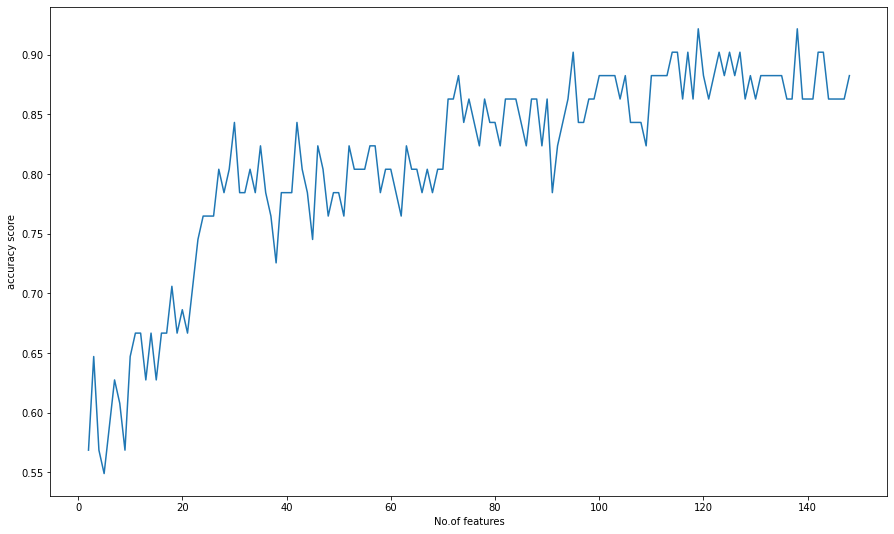

In [ ]:
#Plotting accuracies vs number of features taken
plt.figure(figsize=(15,9))
plt.plot(k_val, acc)
plt.xlabel("No.of features")
plt.ylabel("accuracy score")
plt.show()

In [ ]:
best_feature_count = k_val[acc.index(max(acc))]
print("The best accuracy was achieved with",best_feature_count,"features")

The best accuracy was achieved with 119 features


### SelectkBest function method

In [ ]:
def select_best_k(k_val):
  x_mod = SelectKBest(f_classif, k=k_val)
  x_new = x_mod.fit_transform(x_train, y_train)
  df_final=  pd.DataFrame(x_new)
  x_val = val_df.drop(columns='class')
  y_val = val_df['class']
  x_val_pred = x_mod.transform(x_val)
  x_val_pred_df = pd.DataFrame(x_val_pred)
  clf = RandomForestClassifier(random_state=0)
  clf.fit(df_final, y_train)
  predictions = clf.predict(x_val_pred_df)
  return (accuracy_score(y_val, predictions),cohen_kappa_score(y_val, predictions))

In [ ]:
acc = []
kpp = []
kval_list=[]
for k_val in range(25, 125):
    metrics = select_best_k(k_val)
    acc.append(metrics[0])
    kpp.append(metrics[1])
    kval_list.append(k_val)

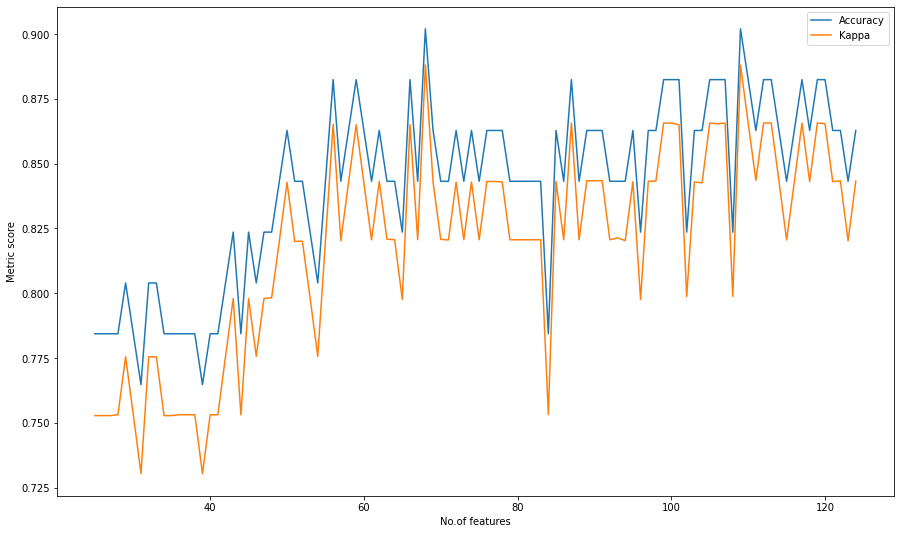

In [ ]:
plt.figure(figsize=(15,9))
plt.plot( kval_list,acc)
plt.plot(kval_list, kpp)
plt.legend(labels=['Accuracy','Kappa'])
plt.xlabel("No.of features")
plt.ylabel("Metric score")
plt.show()


In [ ]:
max_value1 = max(acc)
max_value2 = max(kpp)
max_index1 = acc.index(max_value1)
max_index2 = kpp.index(max_value2)
best_k = kval_list[max_index1]
print("The best accuracy was achieved with",best_k,"features")

The best accuracy was achieved with 68 features


### We are proceeding ahead with the features given by SelectKBest function as it has relatively less number of features as compared to the Pearson Method.


## Part 4: Cross Validation and HyperParameter Tuning

### We are using the RandomizedSearchCV module from sklearn for hyperparameter tuning and cross validation. 



In [ ]:
# defining parameters grid to randomize search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid with paramaeters defined
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
x_mod = SelectKBest(f_classif, k=best_k)
x_new = x_mod.fit_transform(x_train, y_train)
df_final=  pd.DataFrame(x_new)
x_val = val_df.drop(columns='class')
y_val = val_df['class']
x_val_pred = x_mod.transform(x_val)
x_val_pred_df = pd.DataFrame(x_val_pred)

In [ ]:
# Use the random grid to search for best hyperparameters along with 3 fold cross validation and fitting the model

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(df_final, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
#printing best parameters
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [ ]:
best_random = rf_random.best_estimator_

# Training Final Algorithm on Whole Training DF and Predicting using whole Testing Dataframe

In [ ]:
x_train_whole = df.drop(columns = ['class'])
y_train_whole = df['class']
x_mod = SelectKBest(f_classif, k=best_k)
x_new = x_mod.fit_transform(x_train_whole, y_train_whole)
df_whole=  pd.DataFrame(x_new)
x_test = df_2.drop(columns='class')
y_test = df_2['class']
x_test_pred = x_mod.transform(x_test)
x_test_pred_df = pd.DataFrame(x_test_pred)

In [ ]:
best_random.fit(df_whole, y_train_whole)
predictions = best_random.predict(x_test_pred_df)
print(classification_report(y_test, predictions))
print('Kappa:',cohen_kappa_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        45
           1       0.84      0.68      0.75        97
           2       0.65      0.95      0.77        21
           3       0.75      0.83      0.79        93
           4       0.79      0.87      0.83        83
           5       1.00      0.86      0.92        14
           6       0.78      0.89      0.83        45
           7       0.65      0.75      0.70        20
           8       0.88      0.75      0.81        89

    accuracy                           0.80       507
   macro avg       0.80      0.82      0.81       507
weighted avg       0.81      0.80      0.80       507

Kappa: 0.7673160025628093
[[37  1  1  0  0  0  5  1  0]
 [ 1 66  4 23  0  0  1  2  0]
 [ 0  0 20  1  0  0  0  0  0]
 [ 0  9  3 77  0  0  0  3  1]
 [ 0  0  1  1 72  0  0  2  7]
 [ 0  1  0  0  1 12  0  0  0]
 [ 3  0  1  0  0  0 40  0  1]
 [ 0  2  1  1  1  0  0 15  0]
 [ 0  0  0  0 17  0  5  0 67]

### Question 3 : Are there any issues with your model that are apparent from the confusion matrix, but not from your performance metrics?
### From the confusion matrix above, it is evident that most classes are correctly classified except the second and the final class. This anomaly explains the reduction in the model accuracy and could be due to less number of training samples of the erroneous classes.  

# References: 
1. Hyperparameter Tuning the Random Forest in Python: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

2. How to find the index of the max value in a list in Python:  https://www.kite.com/python/answers/how-to-find-the-index-of-the-max-value-in-a-list-in-python